# Bone age prediction of hand radiographs using Neural Networks

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras import layers, Input
from tensorflow.keras.layers import Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model
import time

import matplotlib as mpl
# setting some matplotlib parameters for plots
mpl.rcParams['figure.figsize'] = (15, 15)
mpl.rcParams['axes.grid'] = False
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams.update({'font.size': 22})


%matplotlib inline
np.random.seed(1)

IMG_SIZE = 224
batch_size = 32
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 1)

In [3]:
# cmap = mpl.cm.get_cmap('plasma')
cmap = mpl.cm.get_cmap('viridis')

colors = [cmap(0.0), cmap(0.25), cmap(0.5), cmap(0.75)]
print(colors)

[(0.267004, 0.004874, 0.329415, 1.0), (0.229739, 0.322361, 0.545706, 1.0), (0.127568, 0.566949, 0.550556, 1.0), (0.369214, 0.788888, 0.382914, 1.0)]


## Retrieve datasets

In [4]:
import os
import zipfile

# Define the data folder location
path = '/content/drive/My Drive/Colab Notebooks/Human Data Analytics/HDA_Project/'
data_dirs = ['Bone Age Training Set', 'Bone Age Validation Set','Bone Age Test Set']
train_dirs = ['boneage-training-dataset', 'dataset_data_file_training-gt-6aaa9791-5bdc-4c6d-9ee9-5a3780a37103']
val_dirs = ['boneage-validation-dataset-1', 'boneage-validation-dataset-2']

train_path = path + 'data/Bone Age Training Set/'
val_path = path + 'data/Bone Age Validation Set/'
test_path = path + 'data/Bone Age Test Set/'
masks_path = path + 'all_training_masks/'
masked_path = path + 'boneage-training-dataset-masked/'

In [5]:
with zipfile.ZipFile(path + 'boneage-training-dataset-masked.zip', 'r') as f:
  f.extractall('.')

In [8]:
!cp -r '/content/drive/MyDrive/Colab Notebooks/Human Data Analytics/HDA_Project/data/Bone Age Validation Set/boneage-validation-dataset-masked' 'boneage-validation-dataset-masked'

In [7]:
!cp -r '/content/drive/MyDrive/Colab Notebooks/Human Data Analytics/HDA_Project/data/Bone Age Test Set/boneage-test-dataset-masked' 'boneage-test-dataset-masked'

In [ ]:
# with zipfile.ZipFile(val_path + val_dirs[0] + '.zip', 'r') as f:
#   f.extractall('.')
# with zipfile.ZipFile(val_path + val_dirs[1] + '.zip', 'r') as f:
#   f.extractall('.')

In [ ]:
# with zipfile.ZipFile(path + 'Bone Age Test Set.zip') as f:
#   f.extractall('.')

In [ ]:
# # Extract data from zip file
# for data_dir in data_dirs:
#   if not os.path.exists(data_dir):
#   # if not os.path.exists(path + 'data/' + data_dir):
#     with zipfile.ZipFile(path + data_dir + '.zip', 'r') as f:
#       f.extractall('.')
#       # f.extractall(path + 'data')
#   if 'Training' in data_dir: # training set has two more zip files
#     for train_dir in train_dirs:
#       if not os.path.exists(train_dir):
#         with zipfile.ZipFile(data_dir + '/' + train_dir + '.zip', 'r') as f:
#           f.extractall('.')
#       # if not os.path.exists(path + 'data/' + data_dir + '/' + train_dir):
#       #   with zipfile.ZipFile(path + 'data/' + data_dir + '/' + train_dir + '.zip', 'r') as f:
#       #     f.extract(path + data_dir)
#   if 'Validation' in data_dir: # validation set is divided in two more zip files
#     for val_dir in val_dirs:
#       if not os.path.exists(val_dir):
#         with zipfile.ZipFile(data_dir + '/' + val_dir + '.zip', 'r') as f:
#           f.extractall('.')
#       # if not os.path.exists(path + 'data/' + data_dir + '/' + val_dir):
#       #   with zipfile.ZipFile(path + 'data/' + data_dir + '/' + val_dir + '.zip', 'r') as f:
#       #     f.extractall(path + 'data/' + data_dir)

In [ ]:
# !cp -R /content/boneage-training-dataset /content/boneage-training-masked
# !mkdir /content/boneage_training_masked
# !rm -r "/content/Bone Age Training Set"
# !mv "/content/Bone Age Validation Set/Validation Dataset.csv" /content
# !rm -r "/content/Bone Age Validation Set"

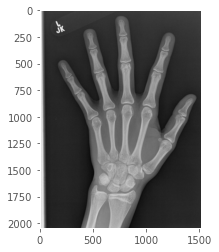

In [ ]:
plt.imshow(cv2.imread(train_dirs[0] + '/1377.png'))

Mask an image as example

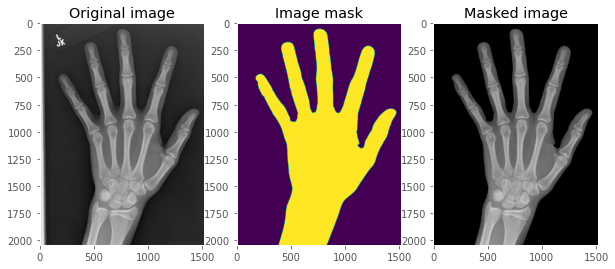

In [ ]:
m_path = path + 'boneage-training-dataset-masks'
image = cv2.imread(train_path + train_dirs[0] + '/1377.png')
mask = cv2.imread(m_path + '/1377.png', 0)

fig, ax = plt.subplots(1,3, figsize=(10, 7))
ax[0].imshow(image)
ax[0].set_title('Original image')
ax[1].imshow(mask)
ax[1].set_title('Image mask')
ax[2].imshow(cv2.bitwise_and(image, image, mask=mask))
ax[2].set_title('Masked image')
plt.show()

## Creating dataframes

In [9]:
!cp  "/content/drive/MyDrive/Colab Notebooks/Human Data Analytics/HDA_Project/utils.py" utils.py
from utils import *

train_df = load_filenames(train_path + 'train.csv', train_path + train_dirs[0])
validation_df = load_filenames(val_path + '/Validation Dataset.csv', val_path + val_dirs[0], val_path + val_dirs[1])
test_df = load_filenames(test_path + '/Bone age ground truth.xlsx', test_path + 'Bone Age Test Set/Test Set Images')

# normalize boneage value to accelerate training
mean_bone_age = train_df['boneage'].mean()
std_bone_age = train_df['boneage'].std()
train_df['boneage_n'] = (train_df['boneage'] - mean_bone_age) / std_bone_age
validation_df['boneage_n'] = (validation_df['boneage'] - mean_bone_age) / std_bone_age
test_df['boneage_n'] = (test_df['boneage'] - mean_bone_age) / std_bone_age

# number of steps between epochs
train_steps = int(np.ceil(train_df.shape[0] / batch_size))
val_steps = int(np.ceil(validation_df.shape[0] / batch_size))

In [10]:
train_df.head(3)

,image,gender(M/F),boneage,boneage_n
0,/content/drive/My Drive/Colab Notebooks/Human ...,0,180,1.279181
1,/content/drive/My Drive/Colab Notebooks/Human ...,0,12,-2.800269
2,/content/drive/My Drive/Colab Notebooks/Human ...,0,94,-0.809109


In [11]:
validation_df.head(3)

,image,gender(M/F),boneage,boneage_n
0,/content/drive/My Drive/Colab Notebooks/Human ...,0,30,-2.363185
1,/content/drive/My Drive/Colab Notebooks/Human ...,1,162,0.842097
2,/content/drive/My Drive/Colab Notebooks/Human ...,0,18,-2.654575


In [12]:
test_df.head(3)

,image,gender(M/F),boneage,boneage_n
0,/content/drive/My Drive/Colab Notebooks/Human ...,1,168.934249,1.010477
1,/content/drive/My Drive/Colab Notebooks/Human ...,1,169.652678,1.027922
2,/content/drive/My Drive/Colab Notebooks/Human ...,1,73.256112,-1.312821


## Preprocessing

### contrast enhancement and normalization

In [ ]:
def ce_norm(df, new_path, factor=2.5):
  func = lambda p: tf.keras.preprocessing.image.save_img(new_path + p.split('/')[-1], 
                                                         image_contrast_enhancement(normalize_values(cv2.imread(p)), factor=factor))
  df.apply(func)
  df['image'] = df['image'].map(lambda p: new_path + p.split('/')[-1])

ce_norm(train_df, train_path + 'Train Set Images Contrast/')
ce_norm(validation_df, val_path + 'Validation Set Images Contrast/', factor=1.5)
ce_norm(test_df, test_path + 'Test Set Images Contrast/')

### apply masks

In [ ]:
mask_model = tf.keras.models.load_model(path + 'Unet100epochs_trainable={}_contrast.h5'.format('True'), compile=False)

In [ ]:
def apply_masking(df, batch_size, path):
  original_names = df['image']
  load_img = lambda file_name : (file_name.split('/')[-1], normalize_values(load_hand_image(file_name, IMG_SIZE)))
  original_imgs = original_names.map(load_img)
  for elem in original_imgs:
    name, img = elem
    pred = mask_model.predict(np.repeat(np.expand_dims(img, axis=0), batch_size, axis=0))
    tf.keras.preprocessing.image.save_img(path + name, pred[0])

apply_masking(validation_df, batch_size, "val_masks/")
apply_masking(test_df, batch_size, "test_masks/")

In [ ]:
apply_masks(train_df, masks_path, IMG_SIZE, train_df.shape[0], masked_path)
apply_masks(validation_df, val_path + 'val_masks/', IMG_SIZE, validation_df.shape[0], val_path + 'boneage-validation-dataset-masked/')
apply_masks(test_df, test_path + 'test_masks/', IMG_SIZE, test_df.shape[0], test_path + 'boneage-test-dataset-masked/')

In [13]:
train_df['image'] = train_df['image'].map(lambda p: 'boneage-training-dataset-masked/' + p.split('/')[-1])
validation_df['image'] = validation_df['image'].map(lambda p: 'boneage-validation-dataset-masked/' + p.split('/')[-1])
test_df['image'] = test_df['image'].map(lambda p: 'boneage-test-dataset-masked/' + p.split('/')[-1])
train_df.loc[1000, 'image']

'boneage-training-dataset-masked/2491.png'

## Data augmentation, Batching, Normalization

In [14]:
datagen_train = ImageDataGenerator(preprocessing_function=lambda x: x/255.,
                                   zoom_range=0.2, rotation_range=25, 
                                   width_shift_range=0.25, height_shift_range=0.25, 
                                   horizontal_flip=True, shear_range = 0.2)
datagen_val = ImageDataGenerator(preprocessing_function=lambda x: x/255., width_shift_range=0.25, 
                                 height_shift_range=0.25, horizontal_flip=True)
datagen_test = ImageDataGenerator(preprocessing_function=lambda x: x/255.)

train_gen = gen_2inputs(datagen_train, train_df, IMG_SIZE, batch_size, shuffle=True, seed=1)
val_gen = gen_2inputs(datagen_val, validation_df, IMG_SIZE, batch_size, shuffle=True, seed=1)
test_gen = gen_2inputs(datagen_test, test_df, IMG_SIZE, test_df.shape[0])

## Models for prediction

In [ ]:
!rm models.py

rm: cannot remove 'models.py': No such file or directory


In [15]:
!cp  "/content/drive/MyDrive/Colab Notebooks/Human Data Analytics/HDA_Project/models.py" models.py
!cp  "/content/drive/MyDrive/Colab Notebooks/Human Data Analytics/HDA_Project/inc_v4.py" inc_v4.py
from models import *

epochs = 50

We use the mean absolute error as metric, as suggested in the papers

In [16]:
def mae_in_months(x, y):
    """
    Return mean absolute error in months

    Arguments:
    x -- predicted value
    y -- ground-truth
    """
    mean_bone_age = train_df['boneage'].mean()
    std_bone_age = train_df['boneage'].std()
    return mean_absolute_error((std_bone_age*x + mean_bone_age), (std_bone_age*y + mean_bone_age)) 

Create the callbacks for the fit function

In [17]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=0, mode='auto', 
                                min_delta=0.0001, cooldown=0, min_lr=0)
csv_logger = CSVLogger('/content/drive/My Drive/Colab Notebooks/Human Data Analytics/HDA_Project/training.log', append=True)

In [ ]:
from keras.callbacks import Callback

class CustomCallback(Callback):
    def __init__(self):
        self.timeref = time.time()
        self.loss = []
        self.val_loss = []
    def on_epoch_end(self, epoch,logs = {}):
        logs['train_time'] = time.time() - self.timeref
        self.loss.append(logs['loss'])
        self.val_loss.append(logs['val_loss'])
    def on_train_end(self, logs = {}):
        plt.figure(figsize=(10, 5))
        plt.yscale=('log')
        plt.plot(range(len(self.loss)), self.loss, label='Training loss')
        plt.plot(range(len(self.loss)), self.val_loss, label='Validation loss')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss Value')
        plt.legend()
        plt.show()

### First place solution

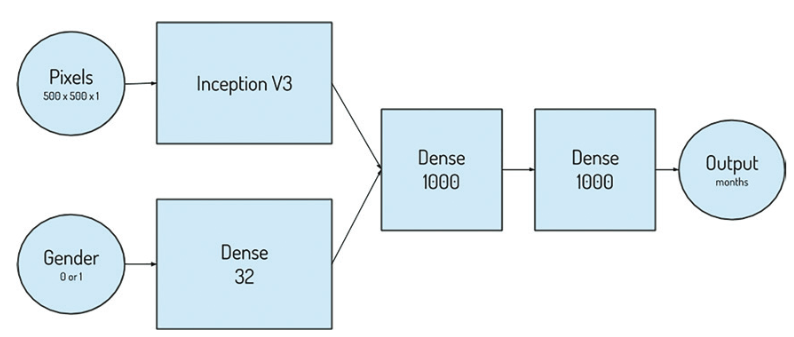

In [18]:
model_name = 'incV3'
gender = True
incV3_model = create_model(model_name, IMG_SHAPE, 'mean_absolute_error', 'adam', mae_in_months, with_gender=gender)

Found 12611 validated image filenames.
Found 12611 validated image filenames.
Epoch 1/50
395/395 [==============================] - ETA: 0s - loss: 0.8522 - mae_in_months: 35.0943 - accuracy: 0.0000e+00Found 1425 validated image filenames.
Found 1425 validated image filenames.

Epoch 1: val_loss improved from inf to 1.38182, saving model to /content/drive/My Drive/Colab Notebooks/Human Data Analytics/HDA_Project/models_checkpoints/incV3_weights.best.hdf5
395/395 [==============================] - 188s 430ms/step - loss: 0.8522 - mae_in_months: 35.0943 - accuracy: 0.0000e+00 - val_loss: 1.3818 - val_mae_in_months: 56.9062 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 2/50
395/395 [==============================] - ETA: 0s - loss: 0.6125 - mae_in_months: 25.2244 - accuracy: 0.0000e+00
Epoch 2: val_loss improved from 1.38182 to 0.71734, saving model to /content/drive/My Drive/Colab Notebooks/Human Data Analytics/HDA_Project/models_checkpoints/incV3_weights.best.hdf5
395/395 [=============

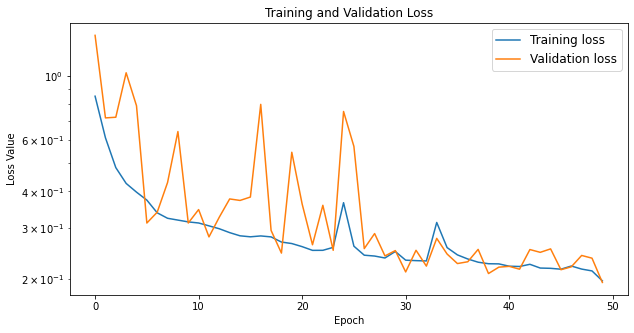

TRAINING FINISHED
Training time: 7889.224729299545
Loss: [0.8521761894226074, 0.6125085949897766, 0.4833715260028839, 0.4262668192386627, 0.3977496325969696, 0.37334585189819336, 0.33752453327178955, 0.3232041299343109, 0.3185794949531555, 0.3140391409397125, 0.31132766604423523, 0.3043249547481537, 0.29737430810928345, 0.2883749008178711, 0.2811761498451233, 0.27896648645401, 0.28090399503707886, 0.2787642776966095, 0.26759427785873413, 0.26442649960517883, 0.257999449968338, 0.25048643350601196, 0.2505858242511749, 0.2565232515335083, 0.36581605672836304, 0.2589212656021118, 0.24105983972549438, 0.23943926393985748, 0.23577921092510223, 0.24825197458267212, 0.2317163199186325, 0.23087693750858307, 0.23027993738651276, 0.31264156103134155, 0.2560853958129883, 0.24163945019245148, 0.2338983565568924, 0.22801576554775238, 0.22525744140148163, 0.22498947381973267, 0.22086551785469055, 0.2203800529241562, 0.2242317944765091, 0.21766337752342224, 0.21718266606330872, 0.21567970514297485, 0

<Figure size 432x288 with 0 Axes>

In [19]:
weight_path = path + 'models_checkpoints/'+ "{}_weights.best.hdf5".format(model_name)
checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, save_best_only=True,
                             mode='min', save_weights_only=True)
callbacks = [checkpoint, reduce_lr]

incV3_history, incV3_time = fit_boneage(incV3_model, train_gen, train_steps, val_gen, val_steps,
                                        epochs, callbacks, gender)

In [ ]:
# load the best version of the model
incV3_model.load_weights(weight_path)

In [20]:
import pickle
with open(path + 'models/{}_history-gender={}-epochs={}'.format(incV3_model.name, gender, epochs), 'wb') as file:
    pickle.dump(incV3_history.history, file, pickle.HIGHEST_PROTOCOL)

In [23]:
with open(path + 'models/{}_history-gender={}-epochs={}'.format(incV3_model.name, gender, epochs), 'rb') as file:
    history=pickle.load(file)

print(history)

{'loss': [0.8521761894226074, 0.6125085949897766, 0.4833715260028839, 0.4262668192386627, 0.3977496325969696, 0.37334585189819336, 0.33752453327178955, 0.3232041299343109, 0.3185794949531555, 0.3140391409397125, 0.31132766604423523, 0.3043249547481537, 0.29737430810928345, 0.2883749008178711, 0.2811761498451233, 0.27896648645401, 0.28090399503707886, 0.2787642776966095, 0.26759427785873413, 0.26442649960517883, 0.257999449968338, 0.25048643350601196, 0.2505858242511749, 0.2565232515335083, 0.36581605672836304, 0.2589212656021118, 0.24105983972549438, 0.23943926393985748, 0.23577921092510223, 0.24825197458267212, 0.2317163199186325, 0.23087693750858307, 0.23027993738651276, 0.31264156103134155, 0.2560853958129883, 0.24163945019245148, 0.2338983565568924, 0.22801576554775238, 0.22525744140148163, 0.22498947381973267, 0.22086551785469055, 0.2203800529241562, 0.2242317944765091, 0.21766337752342224, 0.21718266606330872, 0.21567970514297485, 0.22120733559131622, 0.21588359773159027, 0.21276

In [22]:
incV3_model.save(path + 'models/{}-gender={}-epochs={}.h5'.format(incV3_model.name, gender, epochs))

In [21]:
plt.savefig(path+'plots/{}-gender={}-epochs={}_train_loss.png'.format(incV3_model.name, gender, epochs))

<Figure size 432x288 with 0 Axes>

### InceptionV4
In this case we took the first-place solution replacing the Inception V3 model with an Inception V4, with the result of concatenating the 32-dimension vector corresponding to the gender with the pixels' vector of 75,264 dimensions (instead of 100,352)

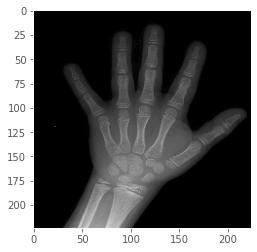

In [ ]:
plt.imshow(cv2.imread(train_df.loc[5253,'image']))

In [ ]:
model_name = 'incV4'
gender = True
incV4_model = create_model(model_name, IMG_SHAPE, 'mean_absolute_error', 'adam', mae_in_months, with_gender=gender)

In [ ]:
weight_path = path + 'models_checkpoints/'+ "{}_weights.best.hdf5".format(model_name)
checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, save_best_only=True,
                             mode='min', save_weights_only=True)
callbacks = [checkpoint, early_stopping, reduce_lr]

epochs = 50

incV4_history, incV4_time = fit_boneage(incV4_model, train_gen, train_steps, val_gen, val_steps,
                                        epochs, [checkpoint], gender)

Found 12611 validated image filenames.
Found 12611 validated image filenames.
Epoch 1/50
395/395 [==============================] - ETA: 0s - loss: 0.8238 - mae_in_months: 33.9249 - accuracy: 0.0000e+00Found 1425 validated image filenames.
Found 1425 validated image filenames.

Epoch 1: val_loss improved from inf to 0.83892, saving model to /content/drive/My Drive/Colab Notebooks/Human Data Analytics/HDA_Project/models_checkpoints/incV4_weights.best.hdf5
395/395 [==============================] - 246s 588ms/step - loss: 0.8238 - mae_in_months: 33.9249 - accuracy: 0.0000e+00 - val_loss: 0.8389 - val_mae_in_months: 34.5482 - val_accuracy: 0.0000e+00
Epoch 2/50
395/395 [==============================] - ETA: 0s - loss: 0.6444 - mae_in_months: 26.5357 - accuracy: 0.0000e+00
Epoch 2: val_loss did not improve from 0.83892
395/395 [==============================] - 227s 576ms/step - loss: 0.6444 - mae_in_months: 26.5357 - accuracy: 0.0000e+00 - val_loss: 1.1565 - val_mae_in_months: 47.6274 - 

In [ ]:
incV4_history.history

In [ ]:
import pickle
with open(path + 'models/{}_history-gender={}-epochs={}'.format(incV4_model.name, gender, epochs), 'wb') as file:
    pickle.dump(incV4_history.history, file, pickle.HIGHEST_PROTOCOL)

In [ ]:
with open(path + 'models/history', 'rb') as file:
    history=pickle.load(file)

print(history)

In [ ]:
incV4_model.load_weights(weight_path)

In [ ]:
incV4_model.save(path + 'models/{}-gender={}-epochs={}.h5'.format(incV4_model.name, gender, epochs))

In [ ]:
plt.savefig(path+'plots/{}-gender={}-epochs={}_train_loss.png'.format(incV4_model.name, gender, epochs))

### Simple CNN
Here we used a simple multi-layer convolution network 


In [ ]:
model_name = 'simple_conv'
gender = True
simple_conv_model = create_model(model_name, IMG_SHAPE, 'mean_absolute_error', 'adam', mae_in_months, with_gender=gender)

395/395 [==============================] - ETA: 0s - loss: 0.7811 - mae_in_months: 32.1662
Epoch 1: val_loss improved from inf to 0.77388, saving model to /content/drive/My Drive/Colab Notebooks/Human Data Analytics/HDA_Project/models_checkpoints/simple_conv_weights.best.hdf5
395/395 [==============================] - 882s 2s/step - loss: 0.7811 - mae_in_months: 32.1662 - val_loss: 0.7739 - val_mae_in_months: 31.8698 - lr: 0.0010


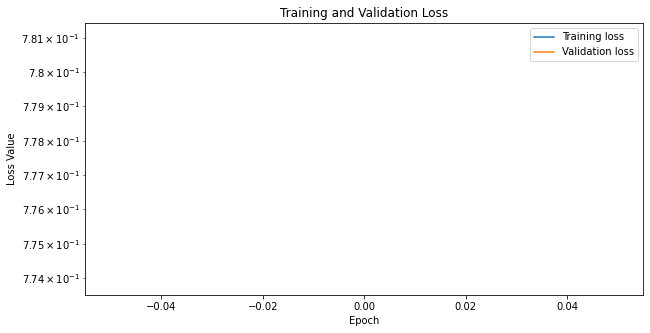

TRAINING FINISHED
Training time: 924.664466381073
Loss: [0.7810739278793335]
MAE in months: [32.16621398925781]
Parameters: 87655737


<Figure size 432x288 with 0 Axes>

In [ ]:
weight_path = path + 'models_checkpoints/'+ "{}_weights.best.hdf5".format(model_name)
checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, save_best_only=True,
                             mode='min', save_weights_only=True)
callbacks = [checkpoint, early_stopping, reduce_lr]

simple_conv_history, simple_conv_time = fit_boneage(simple_conv_model, train_gen, train_steps, val_gen, val_steps,
                                                    epochs, callbacks, gender)

In [ ]:
simple_conv_model.load_weights(weight_path)

### VGG16

It seems to be one of the best architectures for image prediction

In [ ]:
model_name = 'vgg16'
gender = True
vgg16_model = create_model(model_name, IMG_SHAPE, 'mean_absolute_error', 'adam', mae_in_months, with_gender=gender)

In [ ]:
weight_path = path + 'models_checkpoints/'+ "{}_weights.best.hdf5".format(model_name)
checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, save_best_only=True,
                             mode='min', save_weights_only=True)
callbacks = [checkpoint, early_stopping, reduce_lr]

vgg16_history, vgg16_time = fit_boneage(vgg16_model, train_gen, train_steps, val_gen, val_steps,
                                        epochs, [checkpoint], gender)

Found 12611 validated image filenames.
Found 12611 validated image filenames.
Epoch 1/30
395/395 [==============================] - ETA: 0s - loss: 0.7796 - mae_in_months: 32.1056Found 1425 validated image filenames.
Found 1425 validated image filenames.

Epoch 1: val_loss improved from inf to 0.77688, saving model to /content/drive/My Drive/Colab Notebooks/Human Data Analytics/HDA_Project/models_checkpoints/vgg16_weights.best.hdf5
395/395 [==============================] - 279s 670ms/step - loss: 0.7796 - mae_in_months: 32.1056 - val_loss: 0.7769 - val_mae_in_months: 31.9937
Epoch 2/30
395/395 [==============================] - ETA: 0s - loss: 0.7668 - mae_in_months: 31.5801
Epoch 2: val_loss did not improve from 0.77688
395/395 [==============================] - 256s 648ms/step - loss: 0.7668 - mae_in_months: 31.5801 - val_loss: 0.7874 - val_mae_in_months: 32.4254
Epoch 3/30
395/395 [==============================] - ETA: 0s - loss: 0.7682 - mae_in_months: 31.6346
Epoch 3: val_loss i

KeyboardInterrupt: ignored

In [ ]:
vgg16_model.load_weights(weight_path)

## Model evaluation

In [24]:
model_name = 'incV3'
gender = True

weight_path = path + 'models_checkpoints/'+ "{}_weights.best.hdf5".format(model_name)
model = create_model(model_name, (IMG_SIZE, IMG_SIZE, 1), 'mean_absolute_error', 'adam', mae_in_months, with_gender=gender)
model.load_weights(weight_path)

In [25]:
# used a fixed dataset for evaluating the algorithm
# test_X, test_Y = next(gen_2inputs(datagen_val, validation_df, IMG_SIZE, 1024, shuffle=True, seed=1))
test_X, test_Y = next(test_gen)

Found 200 validated image filenames.
Found 200 validated image filenames.


In [27]:
pred_Y = std_bone_age * model.predict(test_X, batch_size = batch_size, verbose = True) + mean_bone_age
test_Y_months = std_bone_age * test_Y + mean_bone_age

7/7 [==============================] - 2s 214ms/step


Text(0, 0.5, 'Predicted Age (Months)')

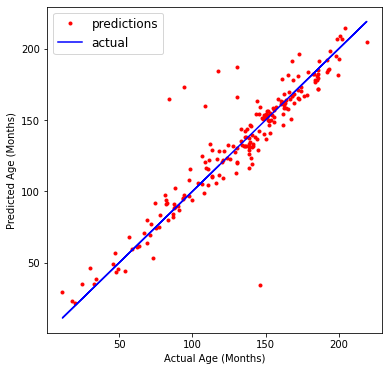

In [28]:
fig, ax1 = plt.subplots(1,1, figsize = (6,6))
ax1.plot(test_Y_months, pred_Y, 'r.', label = 'predictions')
ax1.plot(test_Y_months, test_Y_months, 'b-', label = 'actual')
ax1.legend()
ax1.set_xlabel('Actual Age (Months)')
ax1.set_ylabel('Predicted Age (Months)')

In [29]:
# Evaluate the model
loss, mae, accuracy = model.evaluate(test_gen, verbose=2, steps=1)

1/1 - 8s - loss: 0.2153 - mae_in_months: 8.8660 - accuracy: 0.0000e+00 - 8s/epoch - 8s/step


In [30]:
# test_gen.reset()
y_pred = model.predict(test_gen, steps=test_df.shape[0])
predict = y_pred.flatten()
predicted_months = mean_bone_age + std_bone_age*(predict)
print("months predicted: {}, real boneage {}".format(str(predicted_months[i]),
      str(test_df.loc[i, 'boneage'])) for i in range(len(predicted_months)))

200/200 [==============================] - 120s 599ms/step
<generator object <genexpr> at 0x7fd34927f900>


## Model comparison

In [ ]:
# changing matplotlib.pyplot style
plt.style.use('ggplot') # R like
# plt.style.use('bmh')
# plt.style.use('fivethirtyeight')

In [ ]:
def plot_bars(values, color, title, xlabel, ylabel):
  bars = ['incV3', 'incV4', 'simple_conv', 'vgg16']
  x_pos = np.arange(len(bars))
  
  plt.bar(x_pos, values, color=colors)
  plt.xticks(x_pos, bars)
  plt.title(title)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.show()

Plot #parameters

In [ ]:
num_params = [incV3_model.count_params(), incV4_model.count_params(), 
              simple_conv_model.count_params(), vgg16_model.count_params()]

plot_bars(num_params, colors, '# Parameters per model', 'Models', '# Parameters')

Plot training time

In [ ]:
tr_times = [incV3_time, incV4_time, simple_conv_time, vgg16_time]

plot_bars(tr_times, colors, 'Training time per model', 'Models', 'Training times')

Plot accuracy/loss

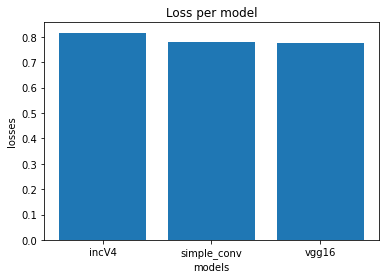

In [ ]:
losses = [incV3_history.history['loss'][-1], incV4_history.history['loss'][-1], 
          simple_conv_history.history['loss'][-1], vgg16_history.history['loss'][-1]] 

plot_bars(losses, colors, 'Loss per model', 'Models', 'Losses')

Plot MAE

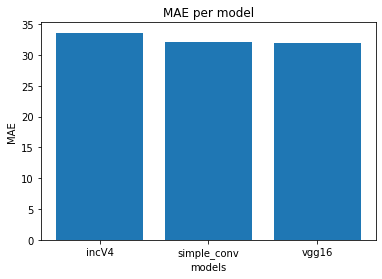

In [ ]:
maes = [incV3_history.history['mae_in_months'][-1], incV4_history.history['mae_in_months'][-1], 
          simple_conv_history.history['mae_in_months'][-1], vgg16_history.history['mae_in_months'][-1]]

plot_bars(maes, colors, 'MAE per model', 'Models', 'MAE')

Plot memory

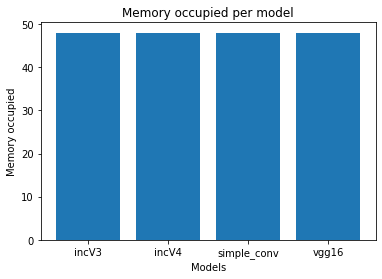

In [ ]:
import sys

incV3_memory = sys.getsizeof(incV3_model)
incV4_memory = sys.getsizeof(incV4_model)
simple_conv_memory = sys.getsizeof(simple_conv_model)
vgg16_memory = sys.getsizeof(vgg16_model)
memories = [incV3_memory, incV4_memory, simple_conv_memory, vgg16_memory]

plot_bars(memories, colors, 'Memory occupied per model', 'Models', 'Memory occupied')

## Gender assesment

We want also to see what changes in terms of learning time and accuracy, when the gender data changes.

### No gender

In [ ]:
# reset generators in order to restart from the first batch
# train_gen.reset()
# val_gen.reset()
# test_gen.reset()

# train_gen = gen_2inputs(datagen_train, train_df, IMG_SIZE, batch_size, shuffle=True, seed=1)
# val_gen = gen_2inputs(datagen_val, validation_df, IMG_SIZE, batch_size, shuffle=True, seed=1)
# test_gen = gen_2inputs(datagen_test, test_df, IMG_SIZE, test_df.shape[0])

In [ ]:
model_name = 'incV4'
gender = False
incV4_nogender = create_model(model_name, IMG_SHAPE, 'mean_absolute_error', 'adam', mae_in_months, with_gender=gender)

In [ ]:
epochs = 1
incV4_nogender_history, incV4_nogender_time = fit_boneage(incV4_nogender, train_gen, train_steps, val_gen, val_steps,
                                                          epochs, callbacks, gender)

### Males only

In [ ]:
# filtering new dataframes
train_df_M = train_df[train_df['gender(M/F)'] == 1]
validation_df_M = validation_df[validation_df['gender(M/F)'] == 1]
test_df_M = test_df[test_df['gender(M/F)'] == 1]

# number of steps between epochs
train_steps_M = int(np.ceil(train_df_M.shape[0] / batch_size))
val_steps_M = int(np.ceil(validation_df_M.shape[0] / batch_size))

print(train_df_M.shape[0], validation_df_M.shape[0], test_df_M.shape[0])

6833 773 100


In [ ]:
# new generators
datagen_train_M = ImageDataGenerator(preprocessing_function=lambda x: x/255.,
                                   zoom_range=0.2, rotation_range=25, 
                                   width_shift_range=0.25, height_shift_range=0.25, 
                                   horizontal_flip=True, shear_range = 0.2)
datagen_val_M = ImageDataGenerator(preprocessing_function=lambda x: x/255., width_shift_range=0.25, 
                                 height_shift_range=0.25, horizontal_flip=True)
datagen_test_M = ImageDataGenerator(preprocessing_function=lambda x: x/255.)

train_gen_M = gen_2inputs(datagen_train_M, train_df_M, IMG_SIZE, batch_size, shuffle=True, seed=1)
val_gen_M = gen_2inputs(datagen_val_M, validation_df_M, IMG_SIZE, batch_size, shuffle=True, seed=1)
test_gen_M = gen_2inputs(datagen_test_M, test_df_M, IMG_SIZE, test_df_M.shape[0])

In [ ]:
model_name = 'incV4'
gender = False
incV4_M = create_model(model_name, IMG_SHAPE, 'mean_absolute_error', 'adam', mae_in_months, with_gender=gender)

Found 6833 validated image filenames.
Found 6833 validated image filenames.
214/214 [==============================] - ETA: 0s - loss: 0.9575 - mae_in_months: 39.4314Found 773 validated image filenames.
Found 773 validated image filenames.

Epoch 1: val_loss did not improve from 0.76825
214/214 [==============================] - 538s 2s/step - loss: 0.9575 - mae_in_months: 39.4314 - val_loss: 0.9347 - val_mae_in_months: 38.4920 - lr: 0.0010


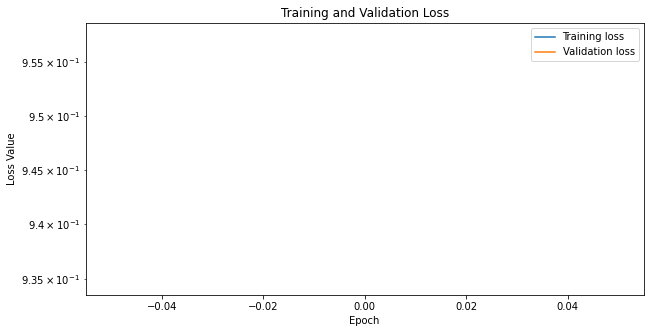

TRAINING FINISHED
Training time: 578.2401781082153
Loss: [0.9574896097183228]
MAE in months: [39.43135452270508]
Parameters: 48383993


In [ ]:
epochs = 1
incV4_M_history, incV4_M_time = fit_boneage(incV4_M, train_gen_M, train_steps_M, val_gen_M, val_steps_M,
                                            epochs, callbacks, 'Male')

### Females only

In [ ]:
# filtering new dataframes
train_df_F = train_df[train_df['gender(M/F)'] == 0]
validation_df_F = validation_df[validation_df['gender(M/F)'] == 0]
test_df_F = test_df[test_df['gender(M/F)'] == 0]

# number of steps between epochs
train_steps_F = int(np.ceil(train_df_F.shape[0] / batch_size))
val_steps_F = int(np.ceil(validation_df_F.shape[0] / batch_size))

print(train_df_F.shape[0], validation_df_F.shape[0], test_df_F.shape[0])

5778 652 100


In [ ]:
# new generators
datagen_train_F = ImageDataGenerator(preprocessing_function=lambda x: x/255.,
                                   zoom_range=0.2, rotation_range=25, 
                                   width_shift_range=0.25, height_shift_range=0.25, 
                                   horizontal_flip=True, shear_range = 0.2)
datagen_val_F = ImageDataGenerator(preprocessing_function=lambda x: x/255., width_shift_range=0.25, 
                                 height_shift_range=0.25, horizontal_flip=True)
datagen_test_F = ImageDataGenerator(preprocessing_function=lambda x: x/255.)

train_gen_F = gen_2inputs(datagen_train_F, train_df_F, IMG_SIZE, batch_size, shuffle=True, seed=1)
val_gen_F = gen_2inputs(datagen_val_F, validation_df_F, IMG_SIZE, batch_size, shuffle=True, seed=1)
test_gen_F = gen_2inputs(datagen_test_F, test_df_F, IMG_SIZE, test_df_F.shape[0])

In [ ]:
model_name = 'incV4'
gender = False
incV4_F = create_model(model_name, IMG_SHAPE, 'mean_absolute_error', 'adam', mae_in_months, with_gender=gender)

Found 5778 validated image filenames.
Found 5778 validated image filenames.
181/181 [==============================] - ETA: 0s - loss: 0.8926 - mae_in_months: 36.7585Found 652 validated image filenames.
Found 652 validated image filenames.

Epoch 1: val_loss did not improve from 0.76825
181/181 [==============================] - 434s 2s/step - loss: 0.8926 - mae_in_months: 36.7585 - val_loss: 0.8156 - val_mae_in_months: 33.5877 - lr: 0.0010


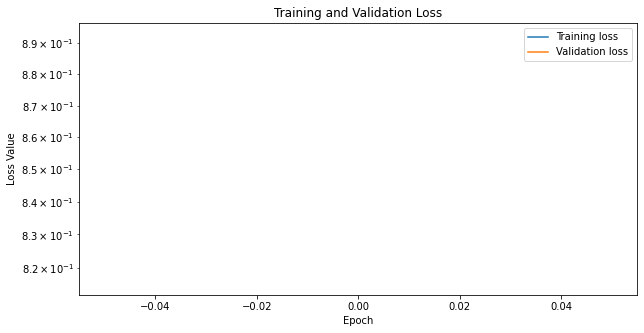

TRAINING FINISHED
Training time: 458.035108089447
Loss: [0.892586350440979]
MAE in months: [36.758514404296875]
Parameters: 48383993


In [ ]:
epochs = 1
incV4_F_history, incV4_F_time = fit_boneage(incV4_F, train_gen_F, train_steps_F, val_gen_F, val_steps_F,
                                            epochs, callbacks, 'Female')

## Attention mechanism
In this case we use again the VGG16 model, this time pretrained with the imagenet weights, and add an attention layer.

This attention layer is exploited to retrieve (hopefully) the most relevant parts of the image which influence the most the training.

In [31]:
from keras.applications.vgg16 import VGG16
from keras.layers import LocallyConnected2D, GlobalAveragePooling2D, Lambda, multiply

def Attention_vgg16(img_shape):
  X_input = Input(img_shape) # (224, 224, 3)

  vgg16 = VGG16(input_shape=img_shape, include_top=False, weights='imagenet')
  vgg16.trainable = False
  X = vgg16(X_input)
  vgg16_shape = vgg16.get_output_shape_at(0)[-1]
  X = BatchNormalization()(X)

  # here we do an attention mechanism to turn pixels in the GAP on an off
  attn_layer = Conv2D(64, kernel_size=1, padding='same', activation='relu')(X)
  attn_layer = Conv2D(16, kernel_size=1, padding='same', activation='relu')(attn_layer)
  attn_layer = LocallyConnected2D(1, kernel_size=1, padding='valid', activation='sigmoid')(attn_layer)

  # fan it out to all of the channels
  upscale_w = np.ones((1, 1, 1, vgg16_shape))
  upscale = Conv2D(vgg16_shape, kernel_size=1, padding='same', activation='linear',
                   use_bias=False, weights=[upscale_w])
  upscale.trainable = False
  attn_layer = upscale(attn_layer)

  X = multiply([attn_layer, X])
  X = GlobalAveragePooling2D()(X)
  gap_mask = GlobalAveragePooling2D()(attn_layer)

  # to account for missing values from the attention model
  X = Lambda(lambda x: x[0]/x[1], name='RescaleGAP')([X, gap_mask])
  X = Dropout(0.5)(X)
  X = Dropout(0.25)(Dense(1024, activation ='elu')(X))

  X = Dense(1, activation='linear')(X)
  return Model(inputs=X_input, outputs=X)

In [ ]:
from keras.applications.vgg16 import VGG16
from keras.layers import LocallyConnected2D, GlobalAveragePooling2D, Lambda, multiply

X_input = Input((IMG_SIZE, IMG_SIZE, 3)) # (224, 224, 3)

vgg16 = VGG16(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet')
# vgg16.trainable = False
vgg16.trainable = True
X = vgg16(X_input)
vgg16_shape = vgg16.get_output_shape_at(0)[-1]
X = BatchNormalization()(X)

# here we do an attention mechanism to turn pixels in the GAP on an off
attn_layer = Conv2D(64, kernel_size=1, padding='same', activation='relu')(X)
attn_layer = Conv2D(16, kernel_size=1, padding='same', activation='relu')(attn_layer)
attn_layer = LocallyConnected2D(1, kernel_size=1, padding='valid', activation='sigmoid')(attn_layer)

# fan it out to all of the channels
upscale_w = np.ones((1, 1, 1, vgg16_shape))
upscale = Conv2D(vgg16_shape, kernel_size=1, padding='same', activation='linear',
                  use_bias=False, weights=[upscale_w])
upscale.trainable = False
attn_layer = upscale(attn_layer)

X = multiply([attn_layer, X])
X = GlobalAveragePooling2D()(X)
gap_mask = GlobalAveragePooling2D()(attn_layer)

# to account for missing values from the attention model
X = Lambda(lambda x: x[0]/x[1], name='RescaleGAP')([X, gap_mask])
X = Dropout(0.5)(X)
X = Dropout(0.25)(Dense(1024, activation ='elu')(X))

X = Dense(1, activation='linear')(X)
attention_model = Model(inputs=X_input, outputs=X)

In [32]:
# attention_model = Attention_vgg16((IMG_SIZE, IMG_SIZE, 3))
attention_model.compile(loss='mse', optimizer='adam', metrics=[mae_in_months])

58889256/58889256 [==============================] - 0s 0us/step


In [33]:
# create generators without merging, with gender data and with rgb images

train_gen = datagen_train.flow_from_dataframe(dataframe=train_df,
        x_col='image', y_col='boneage_n', batch_size=batch_size, seed=1, shuffle=True, class_mode='other',
        target_size=(IMG_SIZE, IMG_SIZE), color_mode='rgb', drop_duplicates=False)
val_gen = datagen_val.flow_from_dataframe(dataframe=validation_df,
        x_col='image', y_col='boneage_n', batch_size=batch_size, seed=1, shuffle=True, class_mode='other',
        target_size=(IMG_SIZE, IMG_SIZE), color_mode='rgb', drop_duplicates=False)

Found 12611 validated image filenames.
Found 1425 validated image filenames.


In [35]:
weight_path = path + 'models_checkpoints/'+ "{}_weights.best.hdf5".format('attention')
checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, save_best_only=True,
                             mode='min', save_weights_only=True)
callbacks = [csv_logger, checkpoint, reduce_lr]

attention_model.fit(train_gen, validation_data=val_gen, epochs=50, callbacks=callbacks)

Epoch 1/50
395/395 [==============================] - ETA: 0s - loss: 0.9097 - mae_in_months: 31.3224
Epoch 1: val_loss improved from inf to 0.79177, saving model to /content/drive/My Drive/Colab Notebooks/Human Data Analytics/HDA_Project/models_checkpoints/attention_weights.best.hdf5
395/395 [==============================] - 190s 480ms/step - loss: 0.9097 - mae_in_months: 31.3224 - val_loss: 0.7918 - val_mae_in_months: 29.0839 - lr: 0.0010
Epoch 2/50
395/395 [==============================] - ETA: 0s - loss: 0.7371 - mae_in_months: 28.2970
Epoch 2: val_loss improved from 0.79177 to 0.71516, saving model to /content/drive/My Drive/Colab Notebooks/Human Data Analytics/HDA_Project/models_checkpoints/attention_weights.best.hdf5
395/395 [==============================] - 170s 429ms/step - loss: 0.7371 - mae_in_months: 28.2970 - val_loss: 0.7152 - val_mae_in_months: 28.0360 - lr: 0.0010
Epoch 3/50
395/395 [==============================] - ETA: 0s - loss: 0.6411 - mae_in_months: 26.1964
Ep

In [38]:
import pickle
with open(path + 'models/{}_history-gender={}-epochs={}'.format('attention_model', gender, epochs), 'wb') as file:
    pickle.dump(attention_model.history.history, file, pickle.HIGHEST_PROTOCOL)

In [36]:
attention_model.save(path + 'models/{}-gender={}-epochs={}.h5'.format('attention_model', gender, epochs))

In [37]:
plt.savefig(path+'plots/{}-gender={}-epochs={}_train_loss.png'.format('attention_model', gender, epochs))

<Figure size 432x288 with 0 Axes>

Show attention maps

TypeError: ignored

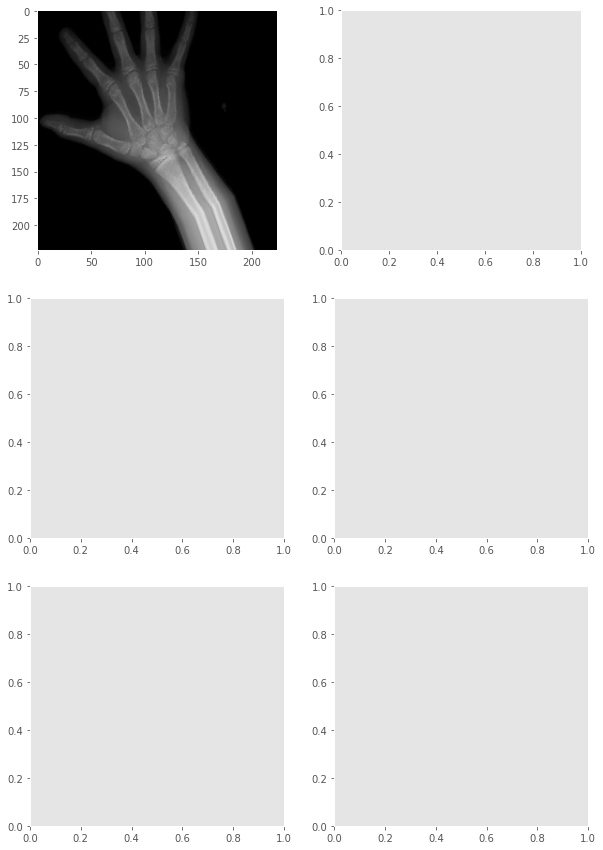

In [ ]:
import keras.backend as K

attn_func = K.function(inputs = [attention_model.layers[0].get_input_at(0)], outputs = [attention_model.layers[5].get_output_at(0)])

fig, axs = plt.subplots(3, 2, figsize = (10, 15))
# [ax.axis('off') for ax in axs.flatten()]

# img_batch, val_batch = next(train_gen)
img_batch, val_batch = train_gen[0]
attn_img_batch = attn_func([img_batch])[0]
for i in [0, 1, 2]:
    img = img_batch[i]
    val = val_batch[i]
    attn_img = attn_img_batch[i]
    # img_ax.imshow(img[:,:,0], cmap = 'bone')
    # axs[i][2*i + 1].imshow(attn_img[:, :, 0], cmap = 'viridis', vmin = 0, vmax = 1, interpolation = 'lanczos')
    axs[i][2*i].imshow(img)
    axs[i][2*i + 1].imshow(attn_img, cmap='viridis')
    axs[i][2*i].axis('off')
    axs[i][2*i + 1].axis('off')

    # g_truth = std_bone_age * val + mean_bone_age
    # axs[i][2*i].set_title('Original image\n ground truth:{}'.format(g_truth/12))
    # pred = std_bone_age * attention_model.predict(img) + mean_bone_age
    # axs[i][2*i + 1].set_title('Attention Map\n prediction:{}'.format(pred[i]/12))

# for i, (img_ax, attn_ax) in zip([0, 1, 2], axs):
#     img = img_batch[i]
#     val = val_batch[i]
#     attn_img = attn_img_batch[i]
#     # img_ax.imshow(img[:,:,0], cmap = 'bone')
#     img_ax.imshow(img)
#     attn_ax.imshow(attn_img[:, :, 0], cmap = 'viridis', vmin = 0, vmax = 1, interpolation = 'lanczos')

#     g_truth = std_bone_age * val + mean_bone_age
#     img_ax.set_title('Original image\n ground truth:{}'.format(g_truth/12))
#     pred = std_bone_age * attention_model.predict(img) + mean_bone_age
#     attn_ax.set_title('Attention Map\n prediction:{}'.format(pred[i]/12))
